## Re-examine SF_Uncert metric in WFD regarding rolling strategy (Batch Run)

In [1]:
# development code
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import glob
import os, sys

In [3]:
# add the path the scripts
sys.path.insert(0, "../scripts/")

In [69]:
# import rubin_sim python modules
import rubin_sim.maf.db as db
import rubin_sim.maf.metrics as metrics
import rubin_sim.maf.slicers as slicers
import rubin_sim.maf.stackers as stackers
import rubin_sim.maf.plots as plots
import rubin_sim.maf.metricBundles as metricBundles
import rubin_sim.maf as maf
from rubin_sim.maf.utils import m52snr

# footprint utils
from rubin_sim.scheduler.utils import footprints

# import convenience functions
from opsimUtils import *

# import custom stacker/metrics from script
from agnstructure import *

# print version
import rubin_sim

rubin_sim.__version__

'0.10.1.dev64+gc32f68b'

### 1. Pull rolling opsims to evaluate 

In [70]:
families = maf.archive.get_family_descriptions()
family_list = families.index.values

# pull roll runs
fam = ["rolling"]
baseline_run = families.loc["rolling", "reference"]
roll_runs = np.concatenate([[baseline_run], families.explode("run").loc[fam, "run"]])
roll_runs

array(['baseline_v2.0_10yrs', 'noroll_v2.0_10yrs',
       'rolling_ns2_rw0.5_v2.0_10yrs', 'rolling_ns3_rw0.5_v2.0_10yrs',
       'rolling_ns2_rw0.9_v2.0_10yrs', 'rolling_ns3_rw0.9_v2.0_10yrs',
       'rolling_bulge_ns2_rw0.5_v2.0_10yrs',
       'rolling_bulge_ns2_rw0.8_v2.0_10yrs',
       'rolling_bulge_ns2_rw0.9_v2.0_10yrs',
       'rolling_all_sky_ns2_rw0.9_v2.0_10yrs', 'roll_early_v2.0_10yrs',
       'six_rolling_ns6_rw0.5_v2.0_10yrs',
       'six_rolling_ns6_rw0.9_v2.0_10yrs', 'rolling_bulge_6_v2.0_10yrs'],
      dtype=object)

### 2. Test SF Uncert on the baseline

In [6]:
dbDir = rubin_sim.data.get_data_dir()
# outDir = "/home/jovyan/mount/ResearchData/MAFOutput/WFD/ResultsDb"
# metricDataPath = "/home/jovyan/mount/ResearchData/MAFOutput/WFD/MetricData"
outDir = "/home/jovyan/mount/ResearchData/MAFOutput/Temp/ResultsDb"
metricDataPath = "/home/jovyan/mount/ResearchData/MAFOutput/Temp/MetricData"

if not os.path.exists(os.path.abspath(outDir)):
    os.makedirs(os.path.abspath(outDir))

if not os.path.exists(os.path.abspath(metricDataPath)):
    os.makedirs(os.path.abspath(metricDataPath))

In [7]:
# create dict for storing dbs
opSimDbs, resultDbs = connect_dbs(dbDir, outDir, dbRuns=roll_runs)

In [8]:
# custom sf bins
nbin = 15
mybins = np.logspace(0, np.log10(3650), nbin+1)
myweights = np.full(nbin, 1/nbin)

# metric + constraint
sfuncert = SFUncertMetric(mag=23, 
                          bins=mybins, weight=myweights, 
                          snr_cut=0)
constraint = 'filter = "g"' + ' and note not like "DD%"'

# custom slicer
nside = 64
wfd_bigdust = footprints.WFD_no_dust_healpixels(nside, dec_max=12.25, dec_min=-72.5, 
                                                dust_limit=0.199)
slicer = slicers.HealpixSubsetSlicer(nside, np.where(wfd_bigdust==1)[0], 
                                     useCache=False)

# create bundle
sfmb = metricBundles.MetricBundle(sfuncert, slicer, constraint)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [9]:
bdict = {0: sfmb}

In [21]:
run = 'baseline_v2.0_10yrs'
gp = metricBundles.MetricBundleGroup(bdict, opSimDbs[run], 
                                     outDir=outDir, 
                                     resultsDb=resultDbs[run])
gp.runAll()

Querying table None with constraint filter = "g" and note not like "DD%" for columns ['filter', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos', 'observationStartMJD', 'fieldDec']
Found 206583 visits
Running:  [0]


/opt/conda/envs/rubin/lib/python3.10/site-packages/rubin_sim/maf/maps/dustMap.py:42: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [23]:
mask = sfmb.metricValues.mask
data = sfmb.metricValues.data[~mask]

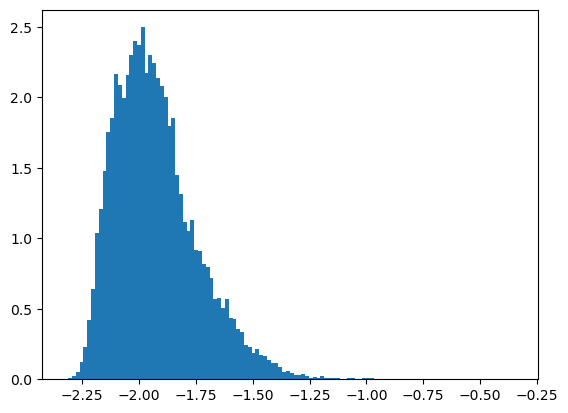

In [25]:
_ = plt.hist(np.log10(data), bins='fd', density=True)

### 3. Test LogTgaps Version
Just return number of paired obs in bins 

In [71]:
# metric + constraint
sfuncertdev = SFUncertMetricDev(mag=23, bins=mybins, weight=myweights, snr_cut=0)

# create bundle
sfmbdev = metricBundles.MetricBundle(sfuncertdev, slicer, constraint)

In [72]:
bdictdev = {0: sfmbdev}

In [73]:
run = 'baseline_v2.0_10yrs'
gpdev = metricBundles.MetricBundleGroup(bdictdev, opSimDbs[run], 
                                        outDir=outDir, 
                                        resultsDb=resultDbs[run])
gpdev.runAll()

Querying table None with constraint filter = "g" and note not like "DD%" for columns ['filter', 'fiveSigmaDepth', 'fieldDec', 'observationStartMJD', 'fieldRA', 'rotSkyPos']
Found 206583 visits
Running:  [0]


/opt/conda/envs/rubin/lib/python3.10/site-packages/rubin_sim/maf/maps/dustMap.py:42: UserWarning: Slicer value of nside 64 different from map value 128, using slicer value
  warnings.warn(


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [74]:
maskdev = sfmbdev.metricValues.mask
datadev = sfmbdev.metricValues.data[~maskdev]

In [75]:
nobs_md = np.median(np.vstack(datadev), axis=0)

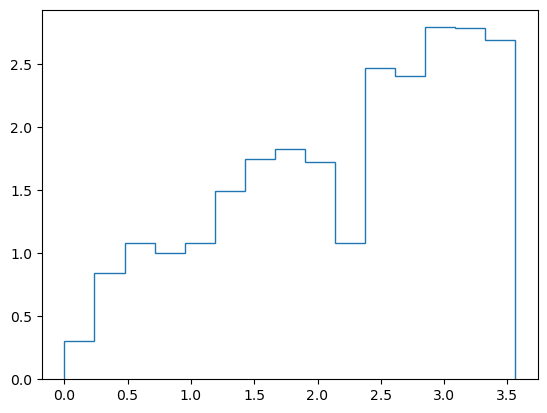

In [68]:
plt.stairs(np.log10(nobs_md))
plt.yscale('log')

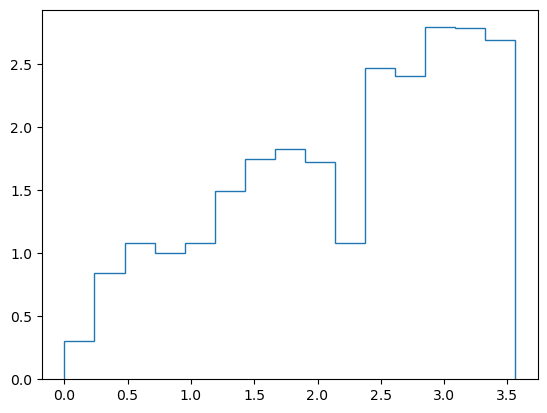

In [76]:
plt.stairs(np.log10(nobs_md), np.log10(mybins))